# Autoencoders

## Use Autoencoders to reconstruct images from the MNIST dataset

In this exercise, we implement an Autoencoder (AE) to reconstruct images from the MNIST dataset. Autoencoders are a type of neural network designed to learn efficient codings of input data by compressing it into a latent space and then reconstructing the original input from this compressed representation.

After training the autoencoder for image reconstruction, we will use it for:

- Image Compression
- kNN Classification using a reduced number of features
- Anomaly detection

### Authors:
- **Dario Piga**

### Date:
- **22nd September 2024**

### References:
- **Autoencoders (AE)**: Baldi, P. (2012). Autoencoders, unsupervised learning, and deep architectures. In Proceedings of ICML Workshop on Unsupervised and Transfer Learning (pp. 37-49).
- **MNIST Dataset**: A dataset of 70,000 28x28 grayscale images of handwritten digits (0-9). [MNIST website](http://yann.lecun.com/exdb/mnist/)
- **Fashion MNIST Dataset**: A dataset of 70,000 28x28 grayscale images of fashion images (10 classes). [Fashion MNIST website](https://www.kaggle.com/datasets/zalando-research/fashionmnist)



## Instructions

Run the following cells to:

1. Import necessary libraries.
2. Download the MNIST dataset.
3. Visualize some of the images.

Make sure to familiarize yourself with the type of data you are working with. For example, check the dimensions of the training and test sets, as well as the shape of each sample in the dataset.

In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transformations: Convert to Tensor and Normalize
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load entire dataset as tensors
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract images and labels
X_train = torch.stack([trainset[i][0] for i in range(len(trainset))]).squeeze()  # From shape [60000, 1, 28, 28] to [60000, 1, 28, 28]
y_train = torch.tensor([trainset[i][1] for i in range(len(trainset))])  # Shape: [60000]

X_test = torch.stack([testset[i][0] for i in range(len(testset))]).squeeze()  # From shape [10000, 1, 28, 28] to [10000, 28, 28]
y_test = torch.tensor([testset[i][1] for i in range(len(testset))])  # Shape: [10000]

# Print dataset shapes
print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set: X_test {X_test.shape}, y_test {y_test.shape}")


Training set: X_train torch.Size([60000, 28, 28]), y_train torch.Size([60000])
Test set: X_test torch.Size([10000, 28, 28]), y_test torch.Size([10000])


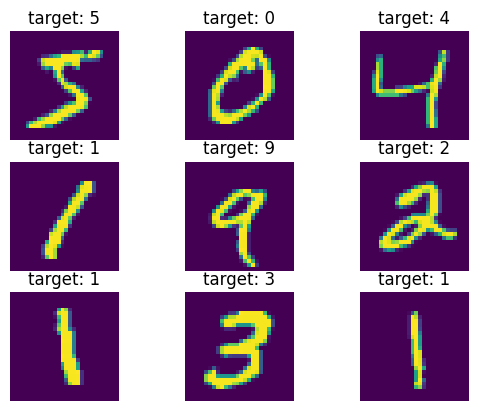

In [3]:
# visualize the images
plt.figure

count = 0
for row in range(3):
    for col in range(3):
        plt.subplot(3, 3, count+1)
        plt.imshow(X_train[count,:])
        plt.title(f"target: {y_train[count].item()}")
        plt.axis('off')
        count +=1

## Exercise 1

In this exercise, you will use the Autoencoder for Image compression.

# Task:

Condider the training images uploaded in the previous cells. Train an Autoencoder that takes these images as inputs and returns the same images. As a size for the latent variable $z$ coming as output of the encoder, you may choose $n_z \leq 30$  


# Suggested steps:

1. Create an `Encoder` as a fully connected neural network, inheriting from the class `nn.Module`. The encoder should take an input dataset $X$ and return the latent variables $z$. Implement this encoder and verify that for a given input $X$, the model outputs a variable of size $n_z$. Suggestion: As input for the encoder, reshape the pixels of the 2-D images (28x28 matrix) into a 1-D vector of size 784 (=28x28). 
 
2. Create a `Decoder` as a fully connected neural network, inheriting from the class `nn.Module`. The decoder should take as input the latent variable $z$ and reconstruct the image $X$. Specifically, the decoder will output the pixel intensities, which should take values between 0 and 1. For this reason, we suggest to use a sigmoid activation function in the final layer. Implement this decoder and verify that for a given latent variable $z$, the model outputs a vector of size 784, which can be shown as $28 \times 28$ image after reshaping.


### AE Architecture:
- The AE should be implemented as a class `Autoencoder` that inherits from `nn.Module`.
- The `forward()` method should:
   - Encode the input to the latent space using the `Encoder`.
   - Decode the latent variable $z$ to reconstruct the input using the `Decoder`.
   
The output of the AE will include the reconstructed input $\hat{X}$. For debugging, it can also returns the latent variable $z$.

### Loss Function:
The total loss minimized during training can be the average of the reconstruction error RE over the dataset (or a minibatch of the dataset). As a reconstruction error, for a given image $X^{i}$, we use the mean square error:

\begin{equation}
RE = \frac{1}{784}\left\| X^{i} - \hat{X}^{i} \right\|^2
\end{equation}

where $X$ is the original input, and $\hat{X}$ is the output of the autoencoder. 

In [4]:
# Create Encoder
class Encoder(nn.Module):
    def __init__(self, H, W, hidden_size_E, nz):
        super(Encoder, self).__init__()

        # Flatten the input
        self.Flatten = nn.Flatten(start_dim=1, end_dim=-1)
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(H * W, hidden_size_E[0])
        self.fc2 = nn.Linear(hidden_size_E[0], hidden_size_E[1])
        self.fc3 = nn.Linear(hidden_size_E[1], nz)
        
        # Activation function
        self.ReLU = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Flatten the input
        x = self.Flatten(x)
        
        # Forward pass through the layers with ReLU activation
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        
        # Output the latent variable z (no activation here)
        z = self.fc3(x)
        return z


In [5]:
# Create Decoder
class Decoder(nn.Module):
    def __init__(self, H, W, nz, hidden_size_D):
        super(Decoder, self).__init__()

        # Define the fully connected layers
        self.fc1 = nn.Linear(nz, hidden_size_D[0])
        self.fc2 = nn.Linear(hidden_size_D[0], hidden_size_D[1])
        self.fc3 = nn.Linear(hidden_size_D[1], H * W)
        
        # Define Unflatten layer to reshape the output back to image dimensions
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(H, W))
        
        # Activation functions
        self.ReLU = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # Forward pass through the fully connected layers with ReLU activation
        x = self.sigmoid(self.fc1(z))
        x = self.sigmoid(self.fc2(x))
        
        # Project back to the original image dimensions
        x = self.fc3(x)
        
        # Apply sigmoid activation to output pixel values in [0, 1]
        x = self.sigmoid(x)
        
        # Unflatten the output to the original image size (H, W)
        x = self.unflatten(x)
        return x


In [6]:
# Create Autoencoder

class AutoEncoder(nn.Module):
    def __init__(self, H, W, hidden_size_E, hidden_size_D, nz):
        super(AutoEncoder, self).__init__()
        # Initialize the encoder and decoder
        self.encoder = Encoder(H, W, hidden_size_E, nz)
        self.decoder = Decoder(H, W, nz, hidden_size_D)

    def forward(self, x):
        # Encode input to latent space
        z = self.encoder(x)
        # Decode latent space back to image
        reconstructed = self.decoder(z)
        return reconstructed, z  # Return reconstructed image and latent vector


Shape of Encoder output: torch.Size([10, 30])
Shape of Decoder output: torch.Size([10, 28, 28])
Shape of Autoencoder output: torch.Size([10, 28, 28])
Shape of latent vector: torch.Size([10, 30])


Text(0.5, 1.0, 'Image generated by a non-trained AE')

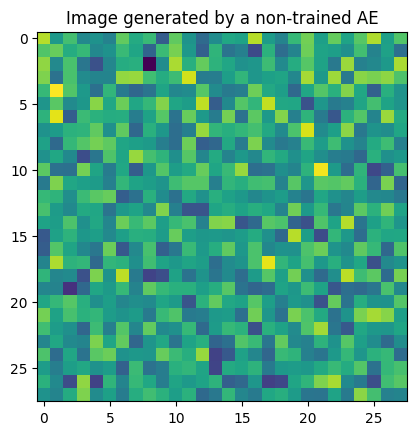

In [7]:
# Test the Autoencoder architecture

# Extract a batch of 10 images
X = X_train[0:10, :, :]  # Shape: (10, 28, 28)
batch_size, H, W = X.shape

# Define model parameters
hidden_size_E = [20, 10]  # Encoder hidden sizes
hidden_size_D = [10, 20]  # Decoder hidden sizes
nz = 30  # Latent space dimension

# Instantiate the encoder model
model_encoder = Encoder(H, W, hidden_size_E, nz)

# Forward pass through the encoder
enc_im = model_encoder(X)
print(f"Shape of Encoder output: {enc_im.shape}")  # Expected: (batch_size, nz)

# Instantiate the decoder model
model_decoder = Decoder(H, W, nz, hidden_size_D)

# Forward pass through the decoder
out = model_decoder(enc_im)
print(f"Shape of Decoder output: {out.shape}")  # Expected: (batch_size, 28, 28)

# Instantiate the full AutoEncoder
model = AutoEncoder(H, W, hidden_size_E, hidden_size_D, nz)

# Forward pass through the autoencoder
X_hat, z = model(X)
print(f"Shape of Autoencoder output: {X_hat.shape}")  # Expected: (batch_size, 28, 28)
print(f"Shape of latent vector: {z.shape}")  # Expected: (batch_size, nz)

# Given a value of z, we can also apply it to the decoder and generate an output
X_new = model.decoder(z)
plt.figure()
plt.imshow(X_new[0,:,:].detach())
plt.title('Image generated by a non-trained AE')

In [8]:
# Define reconstruction error (Mean Squared Error)
def reconstruction_error(X_hat, X):
    # Mean squared error between the reconstructed images and the original images
    RE = torch.nn.functional.mse_loss(X_hat, X, reduction='mean')  # Use PyTorch's built-in MSE function
    return RE

# Example usage:
RE = reconstruction_error(X_hat, X)
print(f"Reconstruction error: {RE.item()}")  # Print the scalar value of the error


Reconstruction error: 0.24066753685474396


In [9]:
# Training

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Instantiate the model
model = AutoEncoder(H, W, hidden_size_E, hidden_size_D, nz)

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use DataLoader for batching
batch_size = 64

# Training loop
n_epochs = 20000
batch_size = 1024

for epoch in range(n_epochs):

    ix = np.random.randint(0, X_train.shape[0], size = batch_size)
    X_train_batch = X_train[ix,:,:] 
    
    # Zero the gradients before the backpropagation step
    optimizer.zero_grad()

    # Forward pass: get the reconstructed output and latent variables
    X_hat, _ = model(X_train_batch)

    # Compute the reconstruction loss (MSE)
    loss = reconstruction_error(X_hat, X_train_batch)

    # Backpropagation step
    loss.backward()

    # Update the parameters using the optimizer
    optimizer.step()

    # Print loss every epoch (or every 10 epochs if preferred)
    if epoch % 100 == 0:  # Change 1 to 10 if you want to print every 10 epochs
        print(f"Epoch: {epoch}, Loss (Reconstruction Error): {loss.item()}")


Epoch: 0, Loss (Reconstruction Error): 0.2376924604177475
Epoch: 100, Loss (Reconstruction Error): 0.09545236825942993
Epoch: 200, Loss (Reconstruction Error): 0.07399453222751617
Epoch: 300, Loss (Reconstruction Error): 0.06870222836732864
Epoch: 400, Loss (Reconstruction Error): 0.068011574447155
Epoch: 500, Loss (Reconstruction Error): 0.06814313679933548
Epoch: 600, Loss (Reconstruction Error): 0.06856885552406311
Epoch: 700, Loss (Reconstruction Error): 0.06742967665195465
Epoch: 800, Loss (Reconstruction Error): 0.0672643780708313
Epoch: 900, Loss (Reconstruction Error): 0.0675748884677887
Epoch: 1000, Loss (Reconstruction Error): 0.06845900416374207
Epoch: 1100, Loss (Reconstruction Error): 0.0674881637096405
Epoch: 1200, Loss (Reconstruction Error): 0.06728149205446243
Epoch: 1300, Loss (Reconstruction Error): 0.06778904050588608
Epoch: 1400, Loss (Reconstruction Error): 0.06762174516916275
Epoch: 1500, Loss (Reconstruction Error): 0.06733250617980957
Epoch: 1600, Loss (Reconst

Epoch: 13200, Loss (Reconstruction Error): 0.03830427676439285
Epoch: 13300, Loss (Reconstruction Error): 0.03822421655058861
Epoch: 13400, Loss (Reconstruction Error): 0.03894273191690445
Epoch: 13500, Loss (Reconstruction Error): 0.03861618414521217
Epoch: 13600, Loss (Reconstruction Error): 0.03752082958817482
Epoch: 13700, Loss (Reconstruction Error): 0.03790644183754921
Epoch: 13800, Loss (Reconstruction Error): 0.038944631814956665
Epoch: 13900, Loss (Reconstruction Error): 0.03729931637644768
Epoch: 14000, Loss (Reconstruction Error): 0.03717568516731262
Epoch: 14100, Loss (Reconstruction Error): 0.03706955164670944
Epoch: 14200, Loss (Reconstruction Error): 0.03777465596795082
Epoch: 14300, Loss (Reconstruction Error): 0.03843942657113075
Epoch: 14400, Loss (Reconstruction Error): 0.037303436547517776
Epoch: 14500, Loss (Reconstruction Error): 0.03792581707239151
Epoch: 14600, Loss (Reconstruction Error): 0.03734191507101059
Epoch: 14700, Loss (Reconstruction Error): 0.03792155

KeyboardInterrupt: 

## Visualizing AutoEncoder Reconstruction

We now visualize the performance of your trained  Autoencoder (AE) by comparing the original test images to the reconstructed images generated by the VAE.

### Steps:
1. **Pass the test images** through the trained AE to obtain the reconstructed images. 
   
2. **Plot the original and reconstructed images** in a 2x10 grid:
   - The first row will display the original images from the test set.
   - The second row will display the corresponding reconstructed images generated by the AE.

In [10]:
# Write your solution here

...

Ellipsis

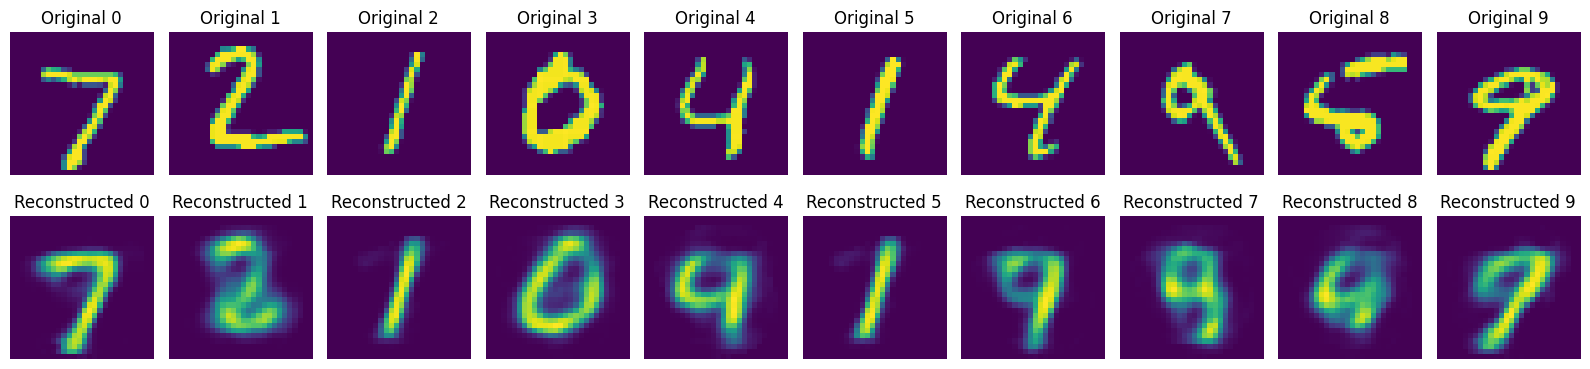

In [13]:
# Pass test images through the VAE to obtain reconstructed images and latent variables
x_hat, z_hat = model(X_test)


# Prepare the plot
plt.figure(figsize=(16, 4))  # Create a larger figure to fit 10 images per row

for count in range(10):  # Display 10 images
    # First row: original images
    plt.subplot(2, 10, count + 1)  # 2 rows and 10 columns grid
    plt.imshow(X_test[count, :].detach().reshape(28, 28))
    plt.title(f'Original {count}')
    plt.axis('off')  # Hide axis for clarity

    # Second row: reconstructed images
    plt.subplot(2, 10, count + 11)  # Start the second row from the 11th subplot
    plt.imshow(x_hat[count, :].detach().reshape(28, 28))
    plt.title(f'Reconstructed {count}')
    plt.axis('off')  # Hide axis for clarity

plt.tight_layout()  # Adjust layout to prevent overlapping of elements
plt.show()  # Display the plot


# Check size (in MB) of the original training datasets and the compressed dataset where only the latent variable z is saved

In [14]:
# save your compressed data and check memory storage

x_hat, z_hat = model(X_train)

size_z_hat =  z_hat.nelement()*z_hat.element_size() # number of elements of z_hat * size in bytes for each element = size in Byte of compressed tensor
size_train_images = X_train.nelement()*X_train.element_size() # size original images

print(f"size in MB of original dataset: {size_train_images/(1024*1024)}") # Note: this is the size after conversion to Tensor of data type: float32 = 4 Bytes/element 
print(f"size in MB of compressed dataset: {size_z_hat/(1024*1024)}")

size in MB of original dataset: 179.443359375
size in MB of compressed dataset: 6.866455078125


# Exercise: Classification with compressed images

Train a knn classifier to predict the digit visualized in the image.

First use original images, then the compressed images.


In both case, compute accuracy and the time taken by a kn--classificator to predict the test images. Comment the results.

In using original images, as features you should use the pixel intensity of the images (after transforming them into a vector)

For compressed, use the latent variables z.

Note: If you use sklear, do not forget to tranfor your Tensors into numpy array.

Note: In the training, use only 5000 images, otherwise the time for prediction will be very high
Note: in Knn, you actually do not really train a model. Most of the time is taken to compute prediction. 

In [21]:
import numpy as np
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Use a subset of the training and test data for having results faster
train_images_subset = X_train[0:5000]  # Use 5000 samples from training set
train_target_subset = y_train[0:5000]  # Corresponding labels

# Flatten the images for KNN
train_images_flat = train_images_subset.view(train_images_subset.size(0), -1)  # Reshape to (batch_size, 28*28)
test_images_flat = X_test.view(X_test.size(0), -1)  # Reshape to (batch_size, 28*28)

# Convert tensors to numpy arrays for sklearn
train_images_np = train_images_flat.numpy()
test_images_np = test_images_flat.numpy()
train_target_np = train_target_subset.numpy()
test_target_np = y_test.numpy()

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors for different K values

# Measure the time taken to fit the classifier
start_time = time.time()

# Fit the classifier on the training data subset
knn.fit(train_images_np, train_target_np)

# Measure the time taken to fit the model
fit_time = time.time() - start_time
print(f"Time to fit the KNN model: {fit_time:.2f} seconds")

# Measure the time taken to predict the test data
start_time = time.time()

# Predict the test labels
test_pred = knn.predict(test_images_np)

# Measure the time taken to predict the test set
predict_time = time.time() - start_time
print(f"Time to predict the test set: {predict_time:.2f} seconds")

# Compute the accuracy
accuracy = accuracy_score(test_target_np, test_pred)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


Time to fit the KNN model: 0.01 seconds
Time to predict the test set: 43.97 seconds
Accuracy on the test set: 93.25%


In [23]:
# repeat for compressed images, using the latent vector z as feature


_, z_hat_train = model(X_train[0:5000])
_, z_hat_test = model(X_test)


# Convert tensors to numpy arrays for sklearn
train_images_compressed_np = z_hat_train.detach().numpy()
test_images_compressed_np =  z_hat_test.detach().numpy()


# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors for different K values

# Measure the time taken to fit the classifier
start_time = time.time()

# Fit the classifier on the training data
knn.fit(train_images_compressed_np, train_target_np)

# Measure the time taken to fit the model
fit_time = time.time() - start_time
print(f"Time to fit the KNN model: {fit_time:.2f} seconds")

# Measure the time taken to predict the test data
start_time = time.time()

# Predict the test labels
test_pred = knn.predict(test_images_compressed_np)

# Measure the time taken to predict the test set
predict_time = time.time() - start_time
print(f"Time to predict the test set: {predict_time:.2f} seconds")

# Compute the accuracy
accuracy = accuracy_score(test_target_np, test_pred)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")



Time to fit the KNN model: 0.00 seconds
Time to predict the test set: 1.67 seconds
Accuracy on the test set: 78.04%


# Anomaly Detection

In this exercise, you should use the trained autoencoder for anomaly detection.

Anomaly detection should be performed on an extended dataset which consists of:

- all images from the MNIST dataset. These images are considered as "normal data" as the autoencoder has already been trained on the MNIST dataset (namely, on digits). 

- 10 additional images from the Fashion MNIST dataset, which should be considered as anomalies in our extended dataset

**Steps of the exercise:**

1. Create the extended dataset by concatenating the test set of MNIST with 10 images from the Fashion MNIST dataset.
   
2. Compute the reconstruction error for all the samples in the extended dataset created in step 1 and order the samples from the largest reconstruction error to the smallest.
   
3. Display the images associated with the 10 largest reconstruction errors and comment the results.

### Run the following cells to download the Fashion MNIST dataset, visualize the images and created the new dataset with test images from MNIST and 10 images from Fashion MNIST.

In [26]:
# Load Fashion MNIST dataset

FashionMNIST_dataset_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)


FashionMNIST_images = torch.stack([FashionMNIST_dataset_train[i][0] for i in range(len(FashionMNIST_dataset_train))])  # Training images
FashionMNIST_images = FashionMNIST_images.squeeze()
FashionMNIST_images.shape

torch.Size([60000, 28, 28])

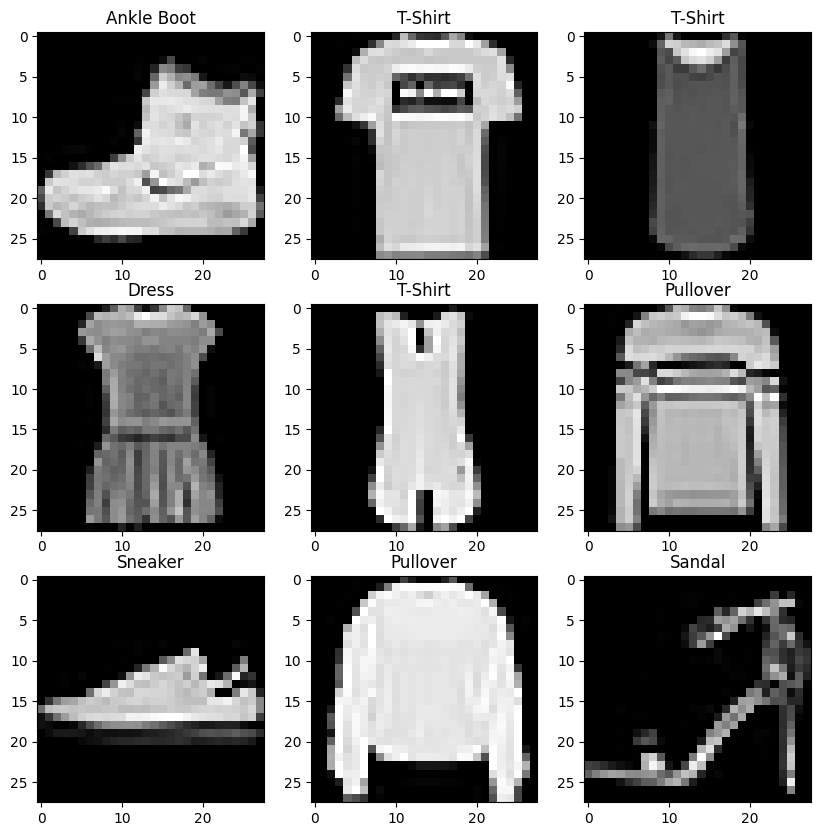

In [27]:
# visualize data

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


cols, rows = 3, 3

fig = plt.figure(figsize = (10,10))
for ind in range(cols*rows):
    x, y = FashionMNIST_dataset_train[ind]
    fig.add_subplot(rows, cols, ind+1)
    plt.title(f"{labels_map[y]}")
    plt.imshow(x.squeeze(), cmap = 'gray')

In [29]:
#concatanete MNIST testa dataset with first 10 images of the FashionMNIST dataset


extended_dataset = torch.cat((X_test, FashionMNIST_images[0:10,:,:]), dim = 0)
print(f"Shape extended dataset: {extended_dataset.shape}")

Shape extended dataset: torch.Size([10010, 28, 28])


In [30]:
import numpy as np

# Pass 10 images from FashionMNIST dataset into your model and compute the reconstructio error

x_hat, _ = model(extended_dataset)

RE = np.zeros(extended_dataset.shape[0])

for ind in range(RE.shape[0]):
    RE[ind] = reconstruction_error(x_hat[ind,:,:], extended_dataset [ind,:,:]).item()

print(RE)

[0.02055555 0.07481374 0.00802729 ... 0.29128385 0.06134782 0.10085806]


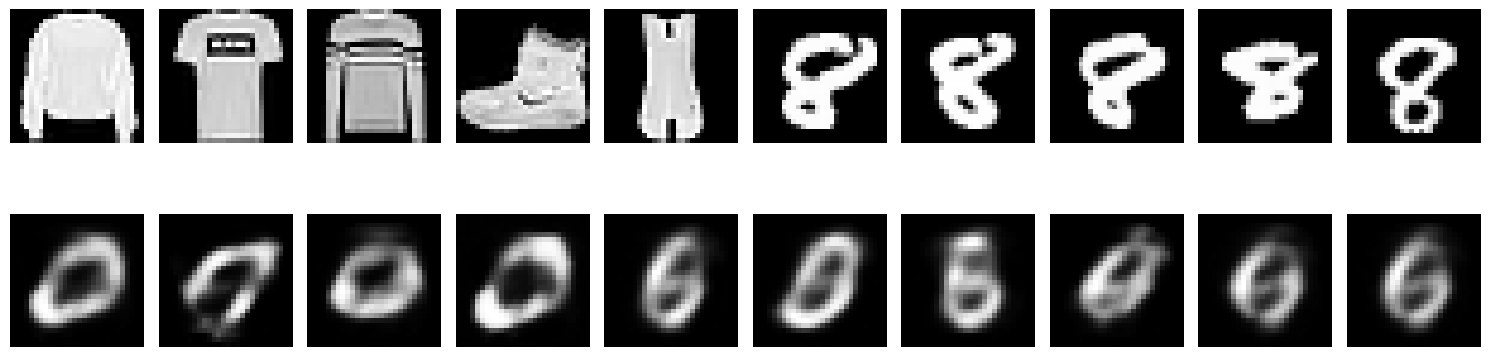

In [39]:
# Sort the indexes of RE in descending order 
sorted_indexes = np.argsort(- RE)  # Get the indices of the top 10 largest values

# Plot the original and reconstructed images
plt.figure(figsize=(15, 5))  # Adjust the figure size for better visualization
for col in range(10):
    
    # Original images (first row)
    plt.subplot(2, 10, col + 1)  # 2 rows, 10 columns, position col+11
    plt.imshow(extended_dataset[sorted_indexes[col], :, :].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')  # Hide the axes for better visualization

    
    # Reconstructed images (second row)
    plt.subplot(2, 10, col + 11)  # 2 rows, 10 columns, position col+1
    plt.imshow(x_hat[sorted_indexes[col], :, :].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')  # Hide the axes for better visualization
    

plt.tight_layout()
plt.show()
